In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.multioutput import MultiOutputRegressor

# =========================
# 1. Load & preprocess data
# =========================
df = pd.read_excel("/content/final.xlsx")

# Extract time-based features if "Date" column exists
if "Date" in df.columns:
    df["Year"] = df["Date"].dt.year
    df["Month"] = df["Date"].dt.month
    df["Quarter"] = df["Date"].dt.quarter
    df = df.drop(columns=["Date"])

# Target columns (Added Risk_Score)
target_cols = [
    "Risk_Score",
    "Growth_Score",
    "Profitability_Score",
    "Stability_Score",
    "Sector_Score",
    "Overall_Score"
]

# Keep Company column separately
company_col = df["Company"]

# Define X and y
X = df.drop(columns=target_cols)  # Keep Company in X for now
y = df[target_cols]

# Select only numeric features except target columns
numeric_cols = X.select_dtypes(include=[np.number]).columns
X_numeric = X[numeric_cols]

# Scale numeric features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_numeric)

# Train/Validation split
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# =========================
# 2. Base Models
# =========================
base_learners = [
    ("rf", RandomForestRegressor(n_estimators=300, max_depth=10, random_state=42)),
    ("xgb", XGBRegressor(n_estimators=500, learning_rate=0.05,
                         max_depth=6, subsample=0.8, colsample_bytree=0.8,
                         random_state=42, n_jobs=-1)),
    ("lgbm", LGBMRegressor(n_estimators=500, learning_rate=0.05,
                           max_depth=-1, subsample=0.8, colsample_bytree=0.8,
                           random_state=42, n_jobs=-1))
]

meta_learner = Ridge(alpha=1.0)

# Stacking Regressor with MultiOutput
stacking_model = MultiOutputRegressor(
    StackingRegressor(estimators=base_learners, final_estimator=meta_learner, n_jobs=-1)
)

# =========================
# 3. Train Model
# =========================
stacking_model.fit(X_train, y_train)

# =========================
# 4. Evaluate Model
# =========================
y_pred = stacking_model.predict(X_val)

for i, col in enumerate(target_cols):
    mse = mean_squared_error(y_val.iloc[:, i], y_pred[:, i])
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val.iloc[:, i], y_pred[:, i])
    r2 = r2_score(y_val.iloc[:, i], y_pred[:, i])
    print(f"\n===== {col} =====")
    print(f"RMSE: {rmse:.3f}")
    print(f"MAE : {mae:.3f}")
    print(f"R²  : {r2:.3f}")



/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/v


===== Risk_Score =====
RMSE: 0.912
MAE : 0.207
R²  : 0.968

===== Growth_Score =====
RMSE: 1.316
MAE : 0.677
R²  : 0.142

===== Profitability_Score =====
RMSE: 0.613
MAE : 0.120
R²  : 0.841

===== Stability_Score =====
RMSE: 2.462
MAE : 1.328
R²  : 0.483

===== Sector_Score =====
RMSE: 1.713
MAE : 0.842
R²  : 0.221

===== Overall_Score =====
RMSE: 0.671
MAE : 0.383
R²  : 0.792


In [2]:
from sklearn.base import clone

print("\n===== Individual Base Model Performance =====")

for name, base_model in base_learners:
    print(f"\n--- {name.upper()} ---")
    # Wrap base model with MultiOutputRegressor for multi-target
    model = MultiOutputRegressor(clone(base_model))
    model.fit(X_train, y_train)
    y_pred_base = model.predict(X_val)

    for i, col in enumerate(target_cols):
        mse = mean_squared_error(y_val.iloc[:, i], y_pred_base[:, i])
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_val.iloc[:, i], y_pred_base[:, i])
        r2 = r2_score(y_val.iloc[:, i], y_pred_base[:, i])
        print(f"{col}: RMSE={rmse:.3f} | MAE={mae:.3f} | R²={r2:.3f}")


===== Individual Base Model Performance =====

--- RF ---
Risk_Score: RMSE=0.830 | MAE=0.193 | R²=0.973
Growth_Score: RMSE=1.366 | MAE=0.704 | R²=0.075
Profitability_Score: RMSE=0.612 | MAE=0.193 | R²=0.842
Stability_Score: RMSE=2.763 | MAE=1.457 | R²=0.348
Sector_Score: RMSE=1.758 | MAE=0.851 | R²=0.181
Overall_Score: RMSE=0.729 | MAE=0.405 | R²=0.754

--- XGB ---
Risk_Score: RMSE=1.153 | MAE=0.216 | R²=0.948
Growth_Score: RMSE=1.321 | MAE=0.686 | R²=0.135
Profitability_Score: RMSE=0.745 | MAE=0.119 | R²=0.766
Stability_Score: RMSE=2.455 | MAE=1.321 | R²=0.486
Sector_Score: RMSE=1.699 | MAE=0.861 | R²=0.234
Overall_Score: RMSE=0.722 | MAE=0.396 | R²=0.759

--- LGBM ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2567
[LightGBM] [Info] Number of data points in the train set: 6059, number of used features: 15
[LightGBM] [Info] Start training

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Risk_Score: RMSE=1.250 | MAE=0.293 | R²=0.939
Growth_Score: RMSE=1.342 | MAE=0.712 | R²=0.107
Profitability_Score: RMSE=0.699 | MAE=0.148 | R²=0.794
Stability_Score: RMSE=2.571 | MAE=1.389 | R²=0.436
Sector_Score: RMSE=1.750 | MAE=0.893 | R²=0.187
Overall_Score: RMSE=0.694 | MAE=0.397 | R²=0.777


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2567
[LightGBM] [Info] Number of data points in the train set: 6059, number of used features: 15
[LightGBM] [Info] Start training from score 69.264884
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2567
[LightGBM] [Info] Number of data points in the train set: 6059, number of used features: 15
[LightGBM] [Info] Start training from score 31.121702
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2567
[LightGBM] [Info] Number of data points in the train set: 6059, number of used features: 15
[LightGBM] [Info] Start trai

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/v

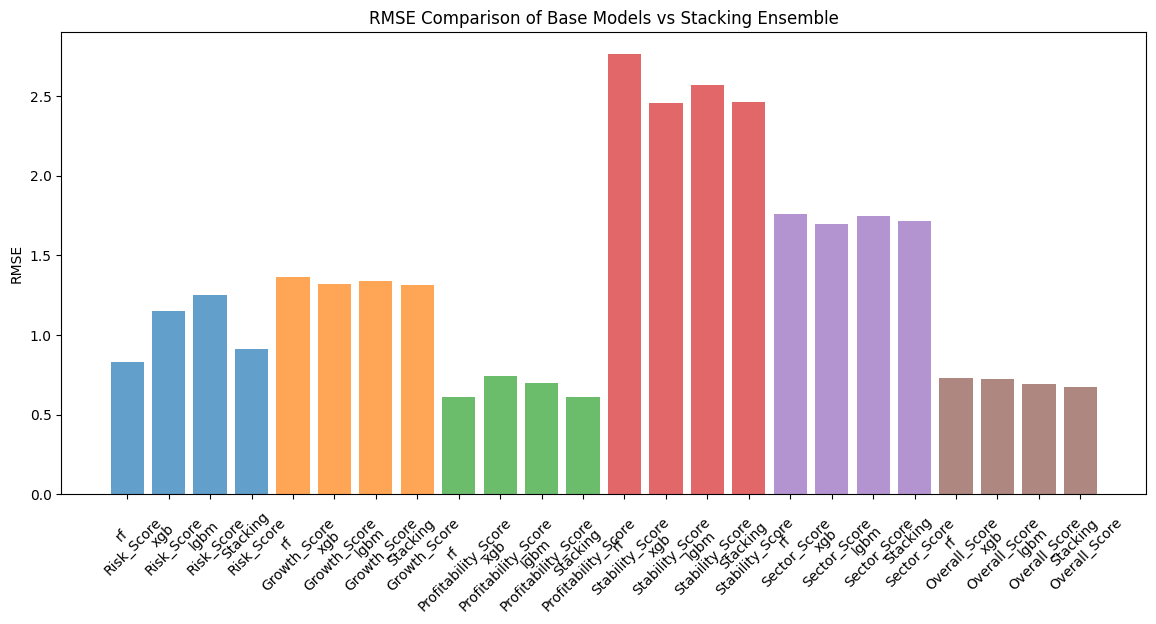

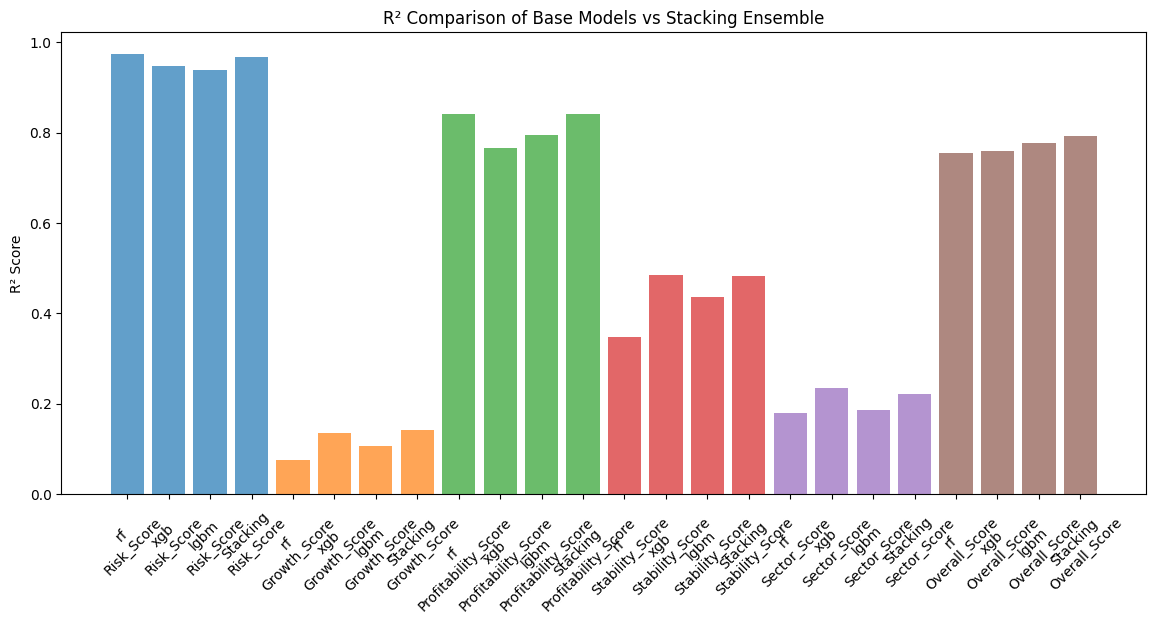

In [3]:
import matplotlib.pyplot as plt

# Store results
results = {}

# Evaluate each base model
for name, base_model in base_learners:
    model = MultiOutputRegressor(clone(base_model))
    model.fit(X_train, y_train)
    y_pred_base = model.predict(X_val)

    results[name] = {}
    for i, col in enumerate(target_cols):
        mse = mean_squared_error(y_val.iloc[:, i], y_pred_base[:, i])
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_val.iloc[:, i], y_pred_base[:, i])
        r2 = r2_score(y_val.iloc[:, i], y_pred_base[:, i])
        results[name][col] = {"RMSE": rmse, "R2": r2}

# Evaluate stacking ensemble
y_pred_stack = stacking_model.predict(X_val)
results["Stacking"] = {}
for i, col in enumerate(target_cols):
    mse = mean_squared_error(y_val.iloc[:, i], y_pred_stack[:, i])
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val.iloc[:, i], y_pred_stack[:, i])
    results["Stacking"][col] = {"RMSE": rmse, "R2": r2}

# Plotting RMSE comparison
plt.figure(figsize=(14,6))
for i, col in enumerate(target_cols):
    rmses = [results[model][col]["RMSE"] for model in results]
    plt.bar([f"{m}\n{col}" for m in results], rmses, alpha=0.7)
plt.ylabel("RMSE")
plt.title("RMSE Comparison of Base Models vs Stacking Ensemble")
plt.xticks(rotation=45)
plt.show()

# Plotting R² comparison
plt.figure(figsize=(14,6))
for i, col in enumerate(target_cols):
    r2s = [results[model][col]["R2"] for model in results]
    plt.bar([f"{m}\n{col}" for m in results], r2s, alpha=0.7)
plt.ylabel("R² Score")
plt.title("R² Comparison of Base Models vs Stacking Ensemble")
plt.xticks(rotation=45)
plt.show()


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/v

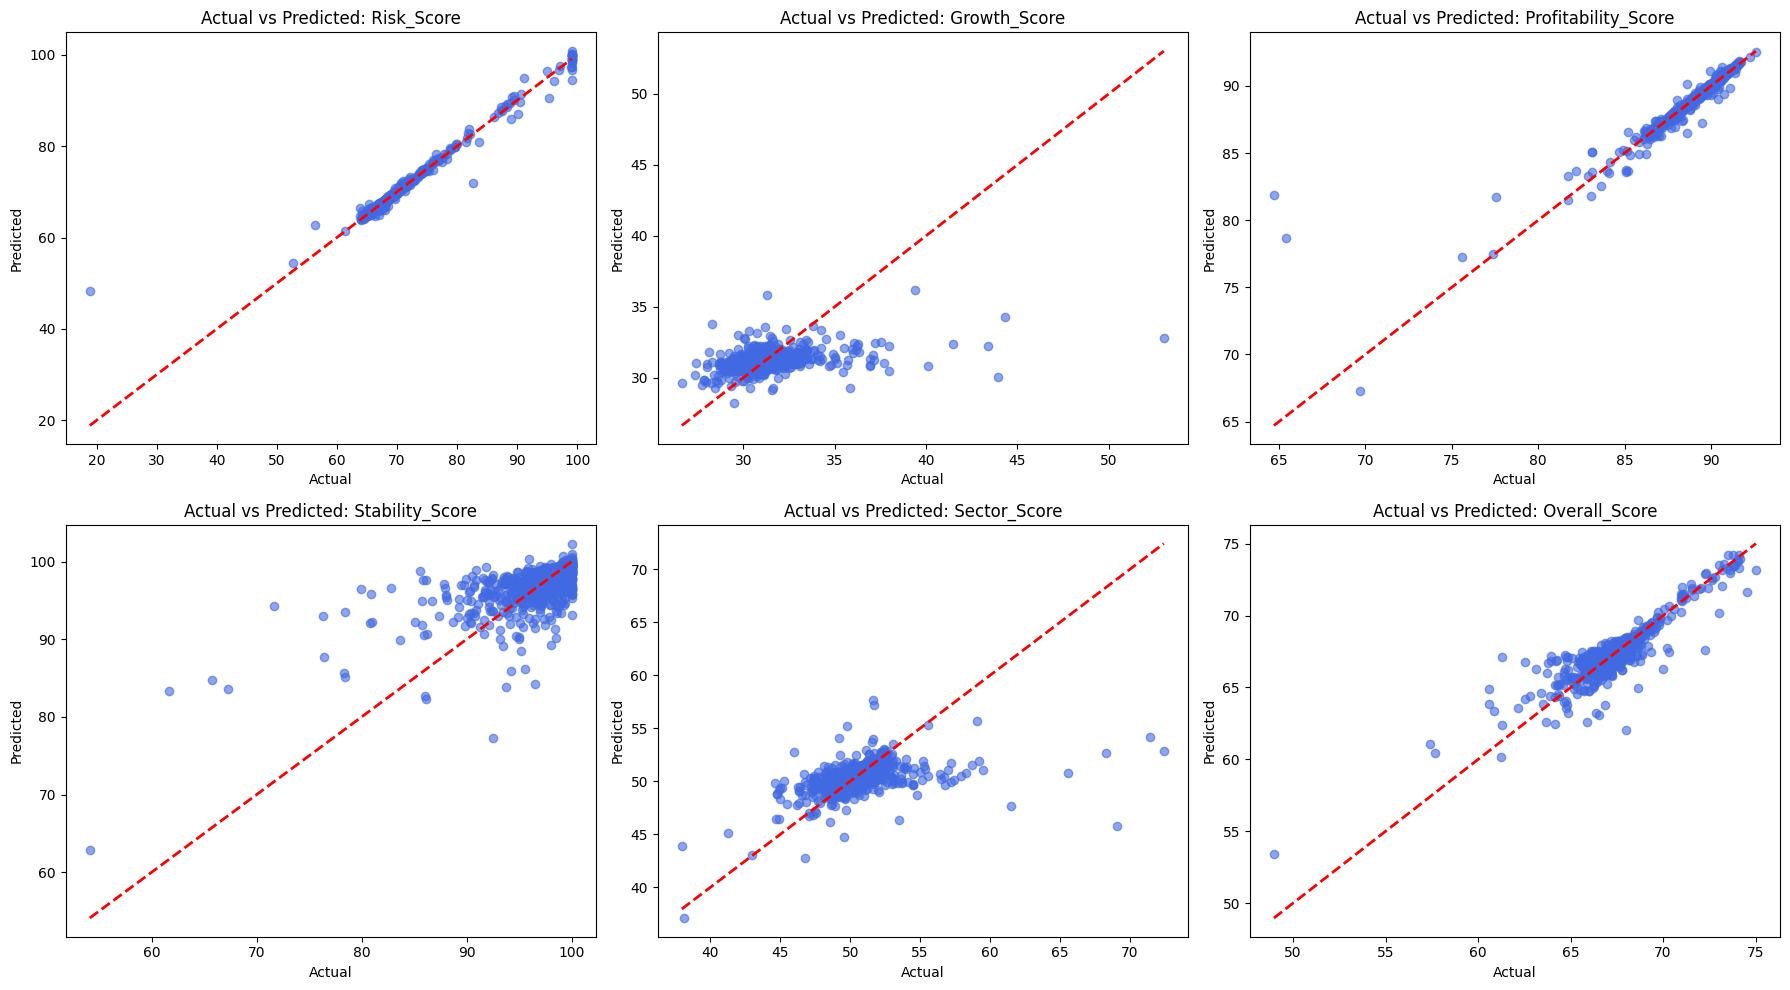

In [4]:
import matplotlib.pyplot as plt

# Predictions from stacking ensemble
y_pred = stacking_model.predict(X_val)

# Plot Actual vs Predicted for each target
plt.figure(figsize=(18, 10))

for i, col in enumerate(target_cols):
    plt.subplot(2, 3, i+1)
    plt.scatter(y_val.iloc[:, i], y_pred[:, i], alpha=0.6, color='royalblue')
    plt.plot([y_val.iloc[:, i].min(), y_val.iloc[:, i].max()],
             [y_val.iloc[:, i].min(), y_val.iloc[:, i].max()],
             'r--', lw=2)  # Perfect prediction line
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"Actual vs Predicted: {col}")

plt.tight_layout()
plt.show()


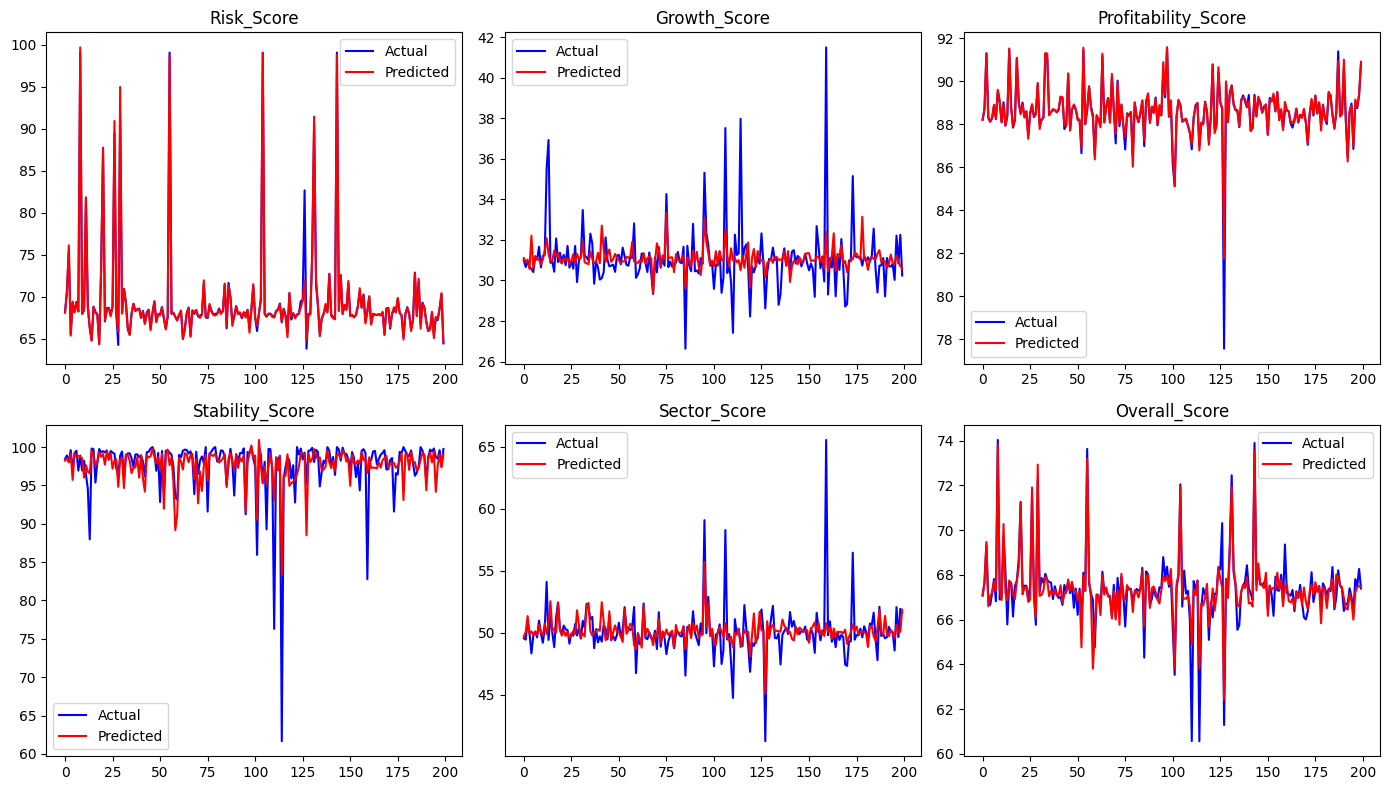

In [6]:
# ==============================
# Visualization (Stacking Ensemble)
# ==============================
n_plot = 200  # number of samples to plot

plt.figure(figsize=(14, 8))
for i, col in enumerate(target_cols):
    plt.subplot(2, 3, i+1)
    plt.plot(y_val.iloc[:n_plot, i].values, label="Actual", color="blue")
    plt.plot(y_pred[:n_plot, i], label="Predicted", color="red")
    plt.title(col)
    plt.legend()

plt.tight_layout()
plt.show()


In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.multioutput import MultiOutputRegressor

# =========================
# 1. Load & Preprocess Data
# =========================
df = pd.read_excel("/content/final.xlsx")

# Extract time-based features if "Date" column exists
if "Date" in df.columns:
    df["Year"] = df["Date"].dt.year
    df["Month"] = df["Date"].dt.month
    df["Quarter"] = df["Date"].dt.quarter
    df = df.drop(columns=["Date"])

# Target columns including Risk_Score
target_cols = [
    "Risk_Score",
    "Growth_Score",
    "Profitability_Score",
    "Stability_Score",
    "Sector_Score",
    "Overall_Score"
]

# Feature / Target split
X = df.drop(columns=target_cols)
y = df[target_cols]

# Keep Company aside, scale only numeric
numeric_cols = X.select_dtypes(include=[np.number]).columns
X_numeric = X[numeric_cols]

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_numeric)

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# =========================
# 2. Base Models (RF + XGB + LGBM)
# =========================
base_learners = [
    ("rf", RandomForestRegressor(n_estimators=300, max_depth=10, random_state=42)),
    ("xgb", XGBRegressor(n_estimators=500, learning_rate=0.05,
                         max_depth=6, subsample=0.8, colsample_bytree=0.8,
                         random_state=42, n_jobs=-1)),
    ("lgbm", LGBMRegressor(n_estimators=500, learning_rate=0.05,
                           max_depth=-1, subsample=0.8, colsample_bytree=0.8,
                           random_state=42, n_jobs=-1))
]

meta_learner = Ridge(alpha=1.0)

# Stacking Regressor wrapped for MultiOutput
stacking_model = MultiOutputRegressor(
    StackingRegressor(estimators=base_learners, final_estimator=meta_learner, n_jobs=-1)
)

# =========================
# 3. Train Ensemble
# =========================
stacking_model.fit(X_train, y_train)

# =========================
# 4. Predict on Validation
# =========================
y_pred = stacking_model.predict(X_val)

# =========================
# 5. Evaluate (MAE, RMSE, R²)
# =========================
metrics_list = []

for i, col in enumerate(target_cols):
    mae = mean_absolute_error(y_val.iloc[:, i], y_pred[:, i])
    rmse = np.sqrt(mean_squared_error(y_val.iloc[:, i], y_pred[:, i]))
    r2 = r2_score(y_val.iloc[:, i], y_pred[:, i])
    metrics_list.append([col, mae, rmse, r2])

metrics_df = pd.DataFrame(metrics_list, columns=["Score", "MAE", "RMSE", "R²"])
print("\n📊 Stacking Ensemble (RF + XGB + LGBM) Metrics:")
print(metrics_df)

# =========================
# 6. (Optional) Save Metrics
# =========================
# metrics_df.to_csv("stacking_metrics_rf_xgb_lgbm.csv", index=False)
# metrics_df.to_excel("stacking_metrics_rf_xgb_lgbm.xlsx", index=False)


KeyboardInterrupt: 

In [12]:
# ===============================
# 📌 Import Libraries
# ===============================
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder

# ===============================
# 📌 STEP 1: Encode Categorical Columns
# ===============================
def encode_categorical_features(X):
    label_encoders = {}
    for col in X.select_dtypes(include=['object']).columns:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        label_encoders[col] = le
    return X, label_encoders

# ===============================
# 📌 STEP 2: Convert datetime columns to numeric
# ===============================
def transform_datetime_features(X):
    datetime_cols = X.select_dtypes(include=['datetime64[ns]', 'datetime64', 'datetimetz']).columns
    if len(datetime_cols) > 0:
        print("Datetime columns detected:", list(datetime_cols))
        for col in datetime_cols:
            X[f"{col}_year"] = X[col].dt.year
            X[f"{col}_month"] = X[col].dt.month
            X[f"{col}_day"] = X[col].dt.day
            X[f"{col}_dayofweek"] = X[col].dt.dayofweek
        X.drop(columns=datetime_cols, inplace=True)
    else:
        print("No datetime columns detected.")
    return X

# ===============================
# 📌 STEP 3: Preprocess X
# ===============================
# Assuming df is your dataframe with features and target
# Example:
# df = pd.read_excel('/content/final.xlsx')

target_cols = ['Risk_Score', 'Growth_Score', 'Profitability_Score',
               'Stability_Score', 'Sector_Score', 'Overall_Score']

X = df.drop(columns=target_cols)
y = df[target_cols]

# Transform datetime features
X = transform_datetime_features(X)

# Encode object columns (Company, Sector, etc.)
X, label_encoders = encode_categorical_features(X)

# ===============================
# 📌 STEP 4: Train-Test Split
# ===============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

mae_scores = {}

# ===============================
# 📌 STEP 5: Loop for each target variable
# ===============================
for target in target_cols:
    print(f"\n🚀 Training for {target}...")
    y_train_target = y_train[target]
    y_test_target = y_test[target]

    rf = RandomForestRegressor(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    )
    xgb = XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        random_state=42,
        n_jobs=-1
    )
    lgbm = LGBMRegressor(
        n_estimators=300,
        learning_rate=0.05,
        random_state=42,
        n_jobs=-1
    )

    stack_model = StackingRegressor(
        estimators=[('rf', rf), ('xgb', xgb), ('lgbm', lgbm)],
        final_estimator=LinearRegression(),
        passthrough=True,
        n_jobs=-1
    )

    stack_model.fit(X_train, y_train_target)
    y_pred = stack_model.predict(X_test)

    mae = mean_absolute_error(y_test_target, y_pred)
    mae_scores[target] = mae
    print(f"{target} MAE: {mae:.4f}")

# ===============================
# 📌 STEP 6: Final MAE Results
# ===============================
print("\n===============================")
print("✅ Final Stacking MAE Scores")
print("===============================")
for target, score in mae_scores.items():
    print(f"{target}: {score:.4f}")


Datetime columns detected: ['FiscalDate']

🚀 Training for Risk_Score...
Risk_Score MAE: 0.1886

🚀 Training for Growth_Score...
Growth_Score MAE: 0.6651

🚀 Training for Profitability_Score...
Profitability_Score MAE: 0.1492

🚀 Training for Stability_Score...
Stability_Score MAE: 1.1919

🚀 Training for Sector_Score...
Sector_Score MAE: 0.8275

🚀 Training for Overall_Score...
Overall_Score MAE: 0.3706

✅ Final Stacking MAE Scores
Risk_Score: 0.1886
Growth_Score: 0.6651
Profitability_Score: 0.1492
Stability_Score: 1.1919
Sector_Score: 0.8275
Overall_Score: 0.3706
